In [1]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm
import pandas_ta as ta

from performance_indicator import *
from trading_computation import *
from plotting_computation import *

In [40]:
LEVERAGE = 10
INITIAL_CAP = 200000
TRAINSIZE = 0.7

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [3]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [4]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [5]:
df

,Date,Close,EFFR
0,2014-01-02,30.055000,0.08
1,2014-01-03,30.035000,0.08
2,2014-01-06,30.160000,0.08
3,2014-01-07,30.260000,0.07
4,2014-01-08,30.150000,0.07
...,...,...,...
1504,2019-12-23,39.160000,1.55
1505,2019-12-24,39.290001,1.55
1506,2019-12-26,39.389999,1.55
1507,2019-12-27,39.419998,1.55


In [6]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
# df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055000,0.08,0.000003
1,2014-01-03,30.035000,0.08,0.000003
2,2014-01-06,30.160000,0.08,0.000003
3,2014-01-07,30.260000,0.07,0.000003
4,2014-01-08,30.150000,0.07,0.000003
...,...,...,...,...
1504,2019-12-23,39.160000,1.55,0.000062
1505,2019-12-24,39.290001,1.55,0.000062
1506,2019-12-26,39.389999,1.55,0.000062
1507,2019-12-27,39.419998,1.55,0.000062


In [13]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * LEVERAGE
df['RSI']=ta.rsi(df.Close, length=15)
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                           0.09
Daily_EFFR                                 0.000004
Daily_return                               0.005885
Daily_excess_return                        0.005881
Daily_excess_leverage_return               0.058814
MA                                         33.91275
Ratio                                       1.03324
std                                        0.643397
upper                                     35.521242
lower                                     32.625956
RSI                                       69.310649
Name: 196, dtype: object

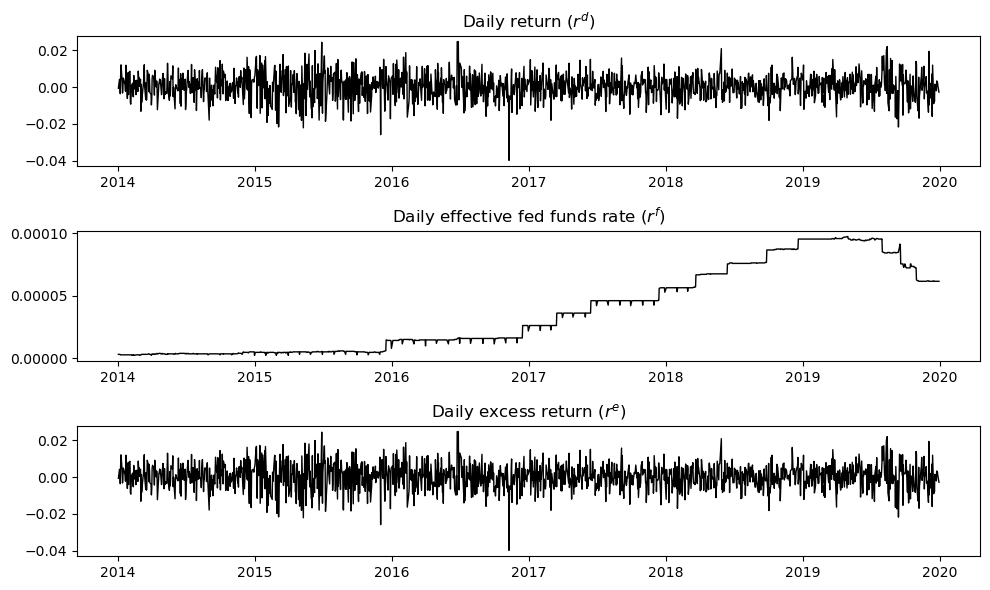

In [83]:
fig, ax = plt.subplots(3, 1, figsize = (10, 6))

ax[0].plot(df['Date'], df['Daily_return'], color = 'black', lw = 1)
ax[0].set_title(r'Daily return ($r^d$)')
ax[1].plot(df['Date'], df['Daily_EFFR'], color = 'black', lw = 1)
ax[1].set_title(r'Daily effective fed funds rate ($r^f$)')
ax[2].plot(df['Date'], df['Daily_excess_return'], color = 'black', lw = 1)
ax[2].set_title(r'Daily excess return ($r^e$)')
plt.tight_layout()

In [14]:
df

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,MA,Ratio,std,upper,lower,RSI
0,2014-01-02,30.055000,0.08,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-03,30.035000,0.08,0.000003,-0.000665,-0.000669,-0.006686,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-06,30.160000,0.08,0.000003,0.004162,0.004159,0.041586,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-01-07,30.260000,0.07,0.000003,0.003316,0.003313,0.033129,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-01-08,30.150000,0.07,0.000003,-0.003635,-0.003638,-0.036380,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2019-12-23,39.160000,1.55,0.000062,-0.002039,-0.002100,-0.021003,39.8245,0.983314,0.436004,40.914510,38.952491,41.467326
1505,2019-12-24,39.290001,1.55,0.000062,0.003320,0.003258,0.032582,39.7755,0.987794,0.438364,40.871409,38.898772,43.660141
1506,2019-12-26,39.389999,1.55,0.000062,0.002545,0.002484,0.024836,39.7200,0.991692,0.411237,40.748091,38.897526,45.347559
1507,2019-12-27,39.419998,1.55,0.000062,0.000762,0.000700,0.007001,39.6725,0.993635,0.386317,40.638292,38.899866,45.868669


## 2. Trading Strategies

### Strategy: Mean Rversion Strategy

[0.96783525 0.9785603  1.00286427 1.0268078  1.03664866]


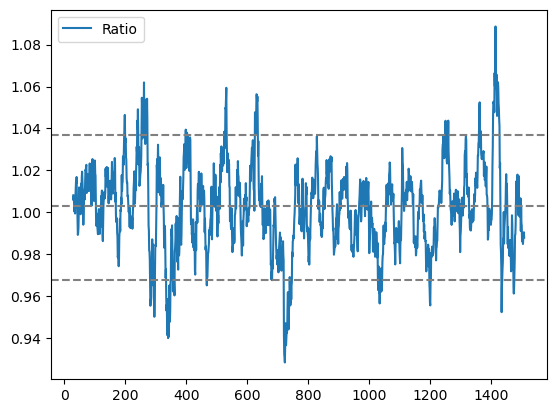

In [158]:
MA = 30
df['MA'] = df['Close'].rolling(MA).mean()
df['Ratio'] = df['Close'] / df['MA']
df['std'] = df['Close'].rolling(MA).std()
df['upper'] = df['MA'] + 2.5 * df['std']
df['lower'] = df['MA'] - 2.5 * df['std']

df['long_MA'] = df['Close'].rolling(50).mean()
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
print(p)
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
df['Ratio'].dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--')

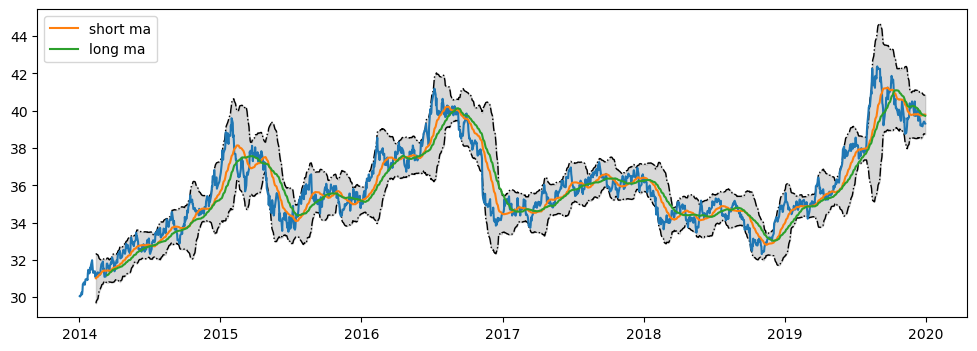

In [161]:
plt.figure(figsize = (12, 4))
plt.plot(df['Date'], df['upper'], color = 'black', lw = 1, ls = '-.')
plt.plot(df['Date'], df['lower'], color = 'black', lw = 1, ls = '-.')
plt.plot(df['Date'], df['Close'])
plt.plot(df['Date'], df['MA'], label = 'short ma')
plt.plot(df['Date'], df['long_MA'], label = 'long ma')
plt.fill_between(df['Date'], df['upper'], df['lower'], color = 'grey', alpha = 0.3)
plt.legend()

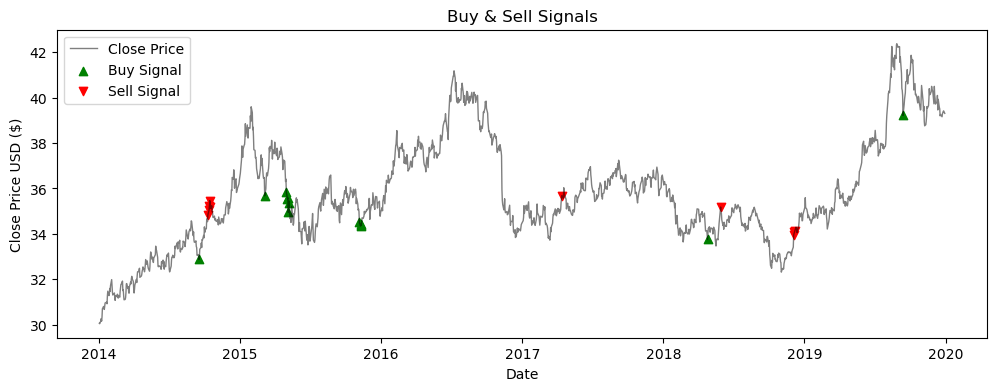

In [160]:
# buy_sig = np.where((df['Close'] < df['long_MA']) & (df['RSI'] <=35), 1, 0) # 
# sell_sig = np.where((df['Close'] > df['long_MA']) & (df['RSI'] >=65), -1, 0) 

buy_sig = np.where((df['MA'] > df['long_MA']) & (df['RSI'] <=35), 1, 0) # 
sell_sig = np.where((df['MA'] < df['long_MA']) & (df['RSI'] >=65), -1, 0) 
signal = buy_sig + sell_sig

plot_signals(df, signal)

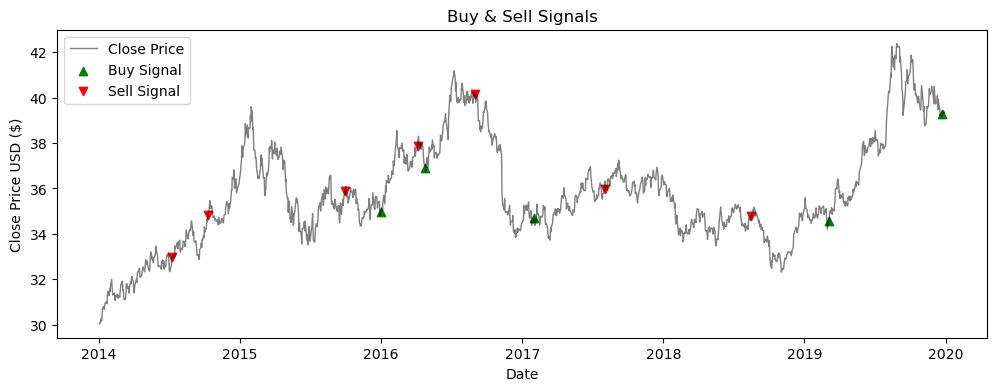

In [182]:
regime = [0]

short_ma = np.array(df['MA'])
long_ma = np.array(df['long_MA'])

rsi = np.array(df['RSI'])

for i in range(1, len(df)):
    if short_ma[i] > long_ma[i] and short_ma[i-1] < long_ma[i-1] and rsi[i] <=50:
        regime.append(1)
    elif short_ma[i] < long_ma[i] and short_ma[i-1] > long_ma[i-1] and rsi[i] >=50:
        regime.append(-1)
    else:
        regime.append(0)
        

plot_signals(df, np.array(regime))

In [156]:
train_set =  df.copy()
short = p[-1] 
long = p[0] 

train_set['Position'] = np.zeros(len(train_set))
train_set['Position'] = np.where((train_set['Ratio'] > short) & (df['RSI'] >= 75), -1, 0)
train_set['Position'] = np.where((train_set['Ratio'] < long) & (df['RSI'] <= 30), 1, train_set['Position'])
# train_set['Position'] = train_set['Position'].ffill()
train_set['Position'] = train_set['Position'].fillna(0)

train_set

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,MA,Ratio,std,upper,lower,RSI,long_MA,Position
0,2014-01-02,30.055000,0.08,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2014-01-03,30.035000,0.08,0.000003,-0.000665,-0.000669,-0.006686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2014-01-06,30.160000,0.08,0.000003,0.004162,0.004159,0.041586,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2014-01-07,30.260000,0.07,0.000003,0.003316,0.003313,0.033129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2014-01-08,30.150000,0.07,0.000003,-0.003635,-0.003638,-0.036380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2019-12-23,39.160000,1.55,0.000062,-0.002039,-0.002100,-0.021003,39.8245,0.983314,0.436004,40.914510,38.734489,41.467326,39.8010,0
1505,2019-12-24,39.290001,1.55,0.000062,0.003320,0.003258,0.032582,39.7755,0.987794,0.438364,40.871409,38.679591,43.660141,39.7744,0
1506,2019-12-26,39.389999,1.55,0.000062,0.002545,0.002484,0.024836,39.7200,0.991692,0.411237,40.748091,38.691908,45.347559,39.7594,0
1507,2019-12-27,39.419998,1.55,0.000062,0.000762,0.000700,0.007001,39.6725,0.993635,0.386317,40.638292,38.706708,45.868669,39.7444,0


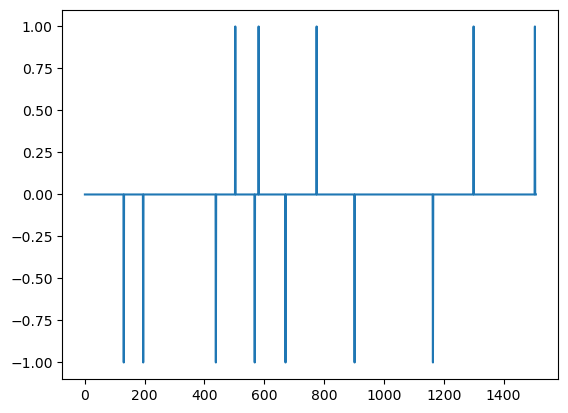

In [177]:
plt.plot(regime)

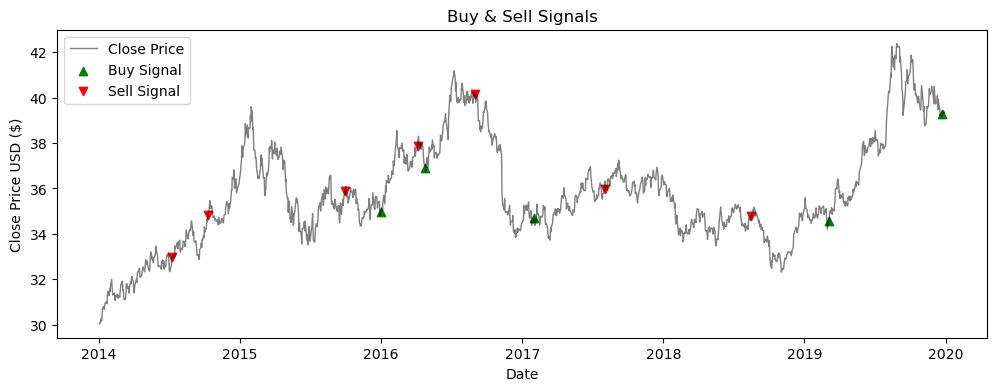

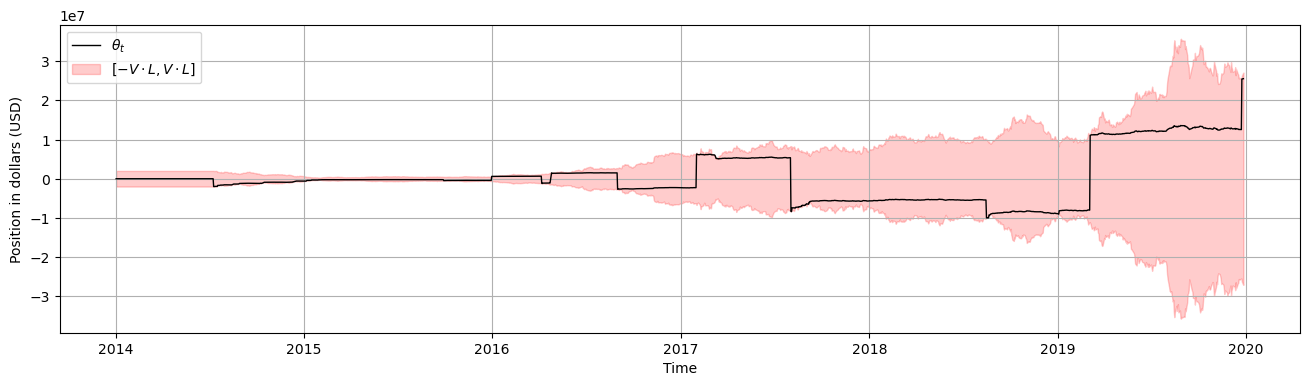

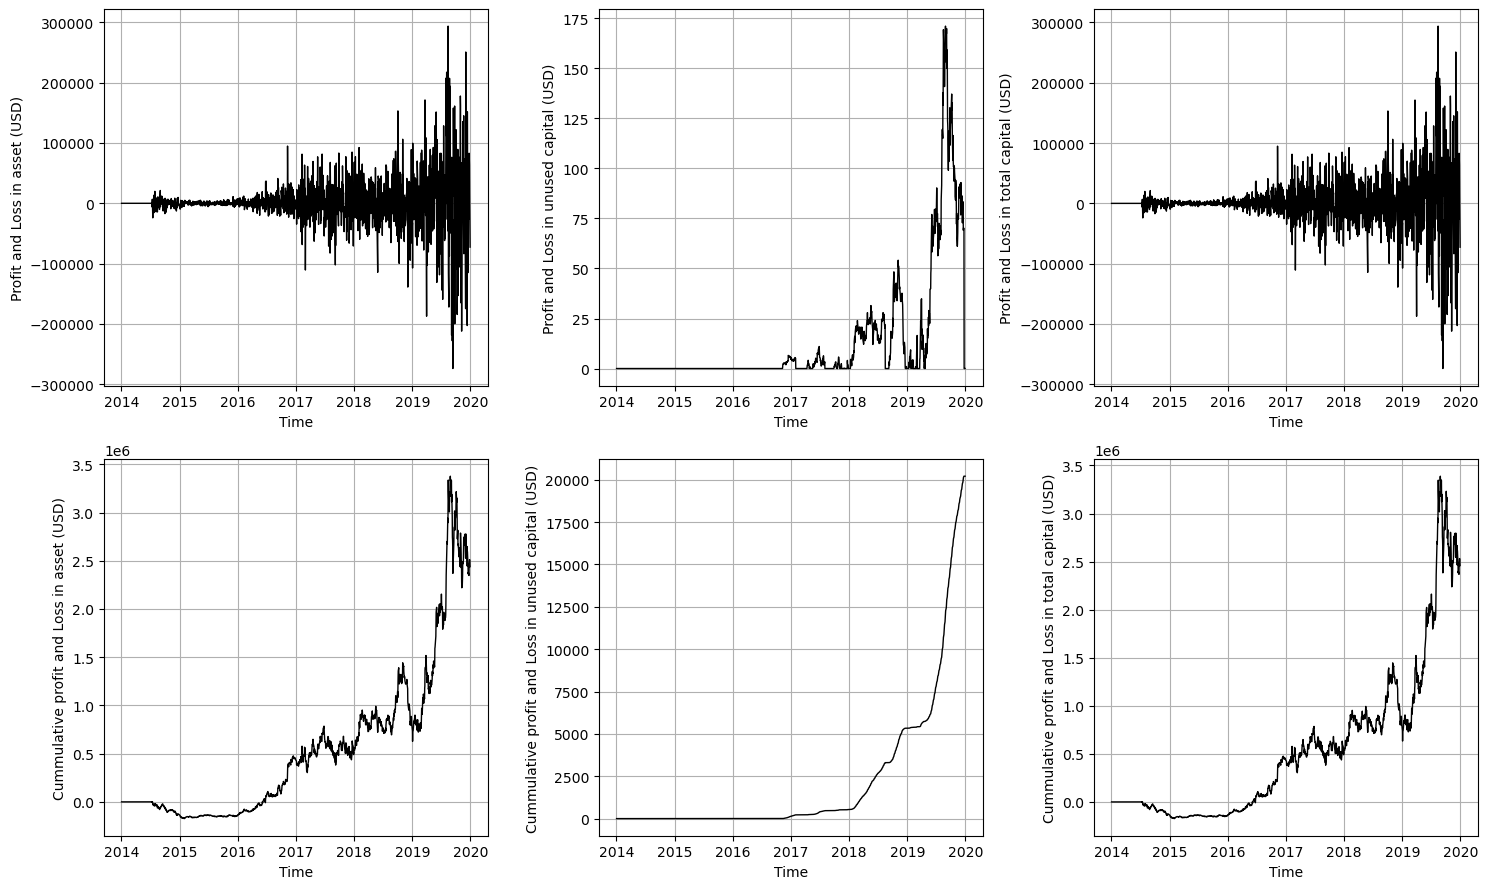

In [183]:
train_set = df
result_train = compute_position_value(df = train_set, 
                           signal = regime, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)

a, b = 0, -1
plot_signals(train_set, np.array(regime))
plot_position(train_set['Date'][a: b], result_train['theta'][a: b], result_train['V'][a: b], leverage=LEVERAGE) 

plot_PnL(train_set['Date'], result_train['dV'], result_train['dVcap'], result_train['dVtot'])

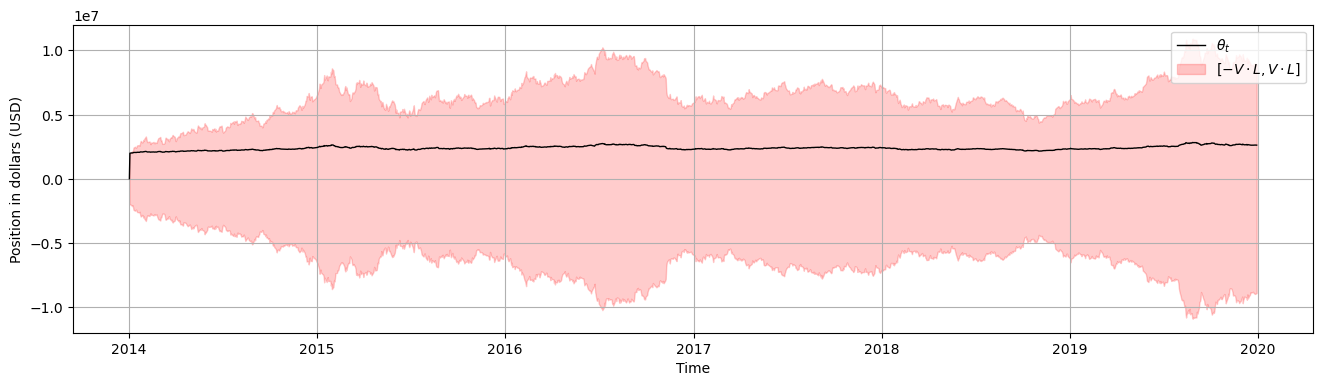

In [ ]:
buy_and_hold_signal = np.zeros(len(df))
buy_and_hold_signal[1] = 1

result = compute_position_value(df = df, 
                           signal = buy_and_hold_signal, 
                           initial_capital = INITIAL_CAP, 
                           max_leverage = LEVERAGE, 
                           reduced_leverage_shorting = False,
                           hold_at_signal_0 = True)
plot_position(df['Date'], result['theta'], result['Vtot'], leverage=LEVERAGE) 

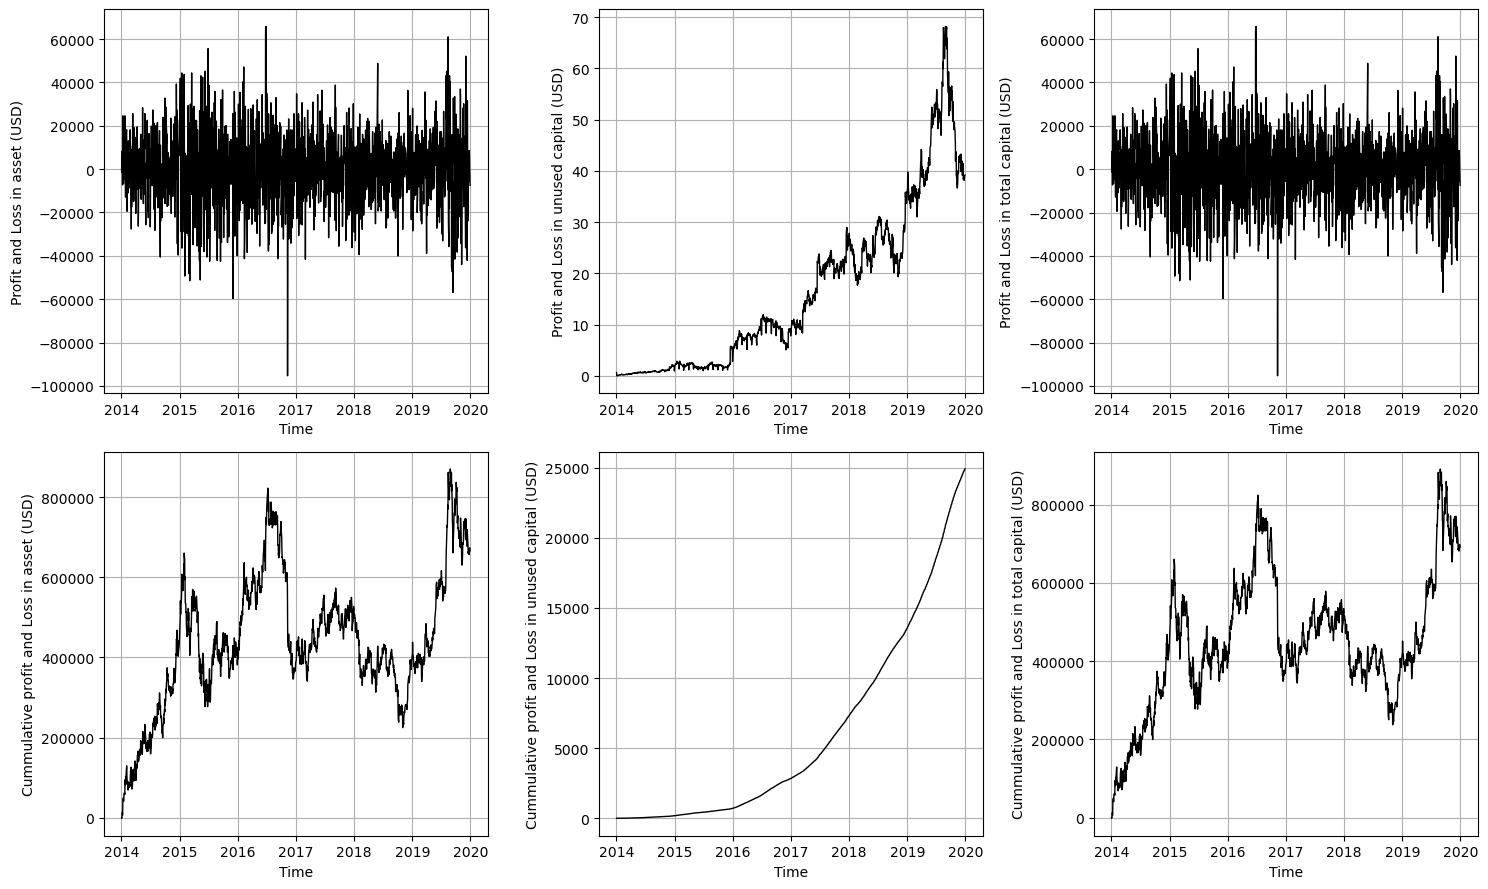

In [ ]:
plot_PnL(df['Date'], result['dV'], result['dVcap'], result['dVtot'])

In [16]:
df

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,MA,Ratio,std,upper,lower
0,2014-01-02,30.055000,0.08,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-03,30.035000,0.08,0.000003,-0.000665,-0.000669,-0.006686,NaN,NaN,NaN,NaN,NaN
2,2014-01-06,30.160000,0.08,0.000003,0.004162,0.004159,0.041586,NaN,NaN,NaN,NaN,NaN
3,2014-01-07,30.260000,0.07,0.000003,0.003316,0.003313,0.033129,NaN,NaN,NaN,NaN,NaN
4,2014-01-08,30.150000,0.07,0.000003,-0.003635,-0.003638,-0.036380,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1504,2019-12-23,39.160000,1.55,0.000062,-0.002039,-0.002100,-0.021003,39.8245,0.983314,0.436004,40.914510,38.952491
1505,2019-12-24,39.290001,1.55,0.000062,0.003320,0.003258,0.032582,39.7755,0.987794,0.438364,40.871409,38.898772
1506,2019-12-26,39.389999,1.55,0.000062,0.002545,0.002484,0.024836,39.7200,0.991692,0.411237,40.748091,38.897526
1507,2019-12-27,39.419998,1.55,0.000062,0.000762,0.000700,0.007001,39.6725,0.993635,0.386317,40.638292,38.899866


In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
# define model


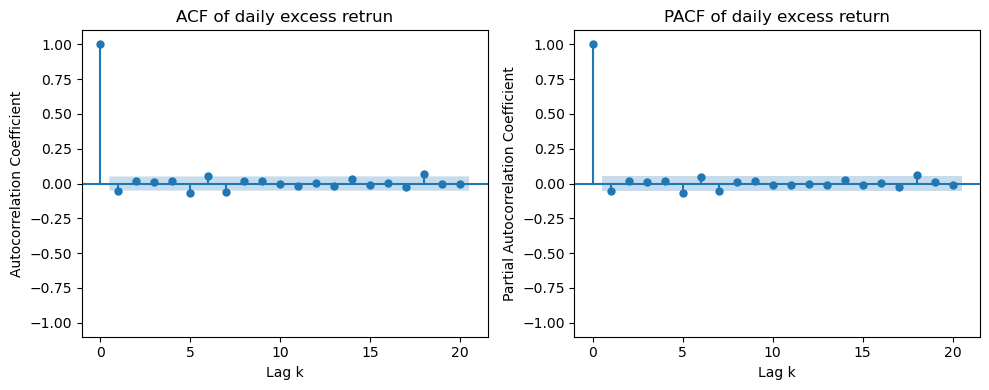

In [21]:
# Plot the ACF
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
LAG = 20
plot_acf(np.array(train_set['Daily_return'].dropna()), lags=LAG, ax=axs[0])  # You can adjust the number of lags as needed
axs[0].set_title(f'ACF of daily excess retrun')
axs[0].set_xlabel('Lag k')
axs[0].set_ylabel('Autocorrelation Coefficient')
axs[0].set_ylim(-1.1, 1.1)


plot_pacf(np.array(train_set['Daily_return'].dropna()), lags=LAG, ax=axs[1])  # You can adjust the number of lags as needed
axs[1].set_title(f'PACF of daily excess return')
axs[1].set_xlabel('Lag k')
axs[1].set_ylabel('Partial Autocorrelation Coefficient')
axs[1].set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()

In [27]:
model = ARIMA(np.array(train_set['Daily_return'].dropna()), order=(5,0,5))

In [30]:


from statsmodels.tsa.arima.model import ARIMA
S = np.array(train_set['Daily_return'].dropna())

time_window = 300
cumsum = [0]

ar_prediction = np.zeros(np.shape(S))

w = np.zeros(np.shape(S))
cash = np.zeros(np.shape(S))

cash[0] = 100
signal = [0]

for i, x in enumerate(S[:-1], 0):
    cumsum.append(cumsum[i] + x)
    ar_prediction[i] = x
    if i>=time_window:
        X = S[0:i]
        train = X
        # train autoregression
        model = ARIMA(train)
        model_fit = model.fit()
        predictions = model_fit.predict(start=len(train), end=len(train), dynamic=False)
        ar_prediction[i] = predictions[len(train)]
    
    if ar_prediction[i] == x:
        w[i+1] = w[i]
        cash[i+1] = cash[i]
        signal.append(0)
    
    if ar_prediction[i] > x: 
        w[i+1] = cash[i]/x  + w[i]
        cash[i+1] = 0
        signal.append(1)
        
    if ar_prediction[i] < x:
        cash[i+1] = w[i]*x + cash[i]
        w[i+1] = 0
        signal.append(-1)


ar_strategy = [a*b for a,b in zip(w,S)]+ cash

IndexError: index 300 is out of bounds for axis 0 with size 1